In [1]:
from pytorch_lightning import Trainer
from catinous.CatsinomModelGramCache import CatsinomModelGramCache
import catinous.CatsinomModelGramCache as catsmodel
from catinous import utils as cutils
from catinous.CatsinomDataset import CatsinomDataset

import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.utils.data import DataLoader
import os
import torchvision.models as models
import torch.nn as nn
import torch
import torch.nn.functional as F
import argparse
import pytorch_lightning as pl
import sklearn 
from sklearn.metrics import confusion_matrix, auc, roc_curve
import torch
import pandas as pd
import seaborn as sns
import pickle
from py_jotools import mut, slurm
import numpy as np
import gc
import hashlib
import dill
import catinous.utils as cutils

%load_ext autoreload
%autoreload 

The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.


# Base training

In [2]:
schedule = False

sparams = {
    'binary': '/home/cir/jhofmanninger/env/candid/bin/python',
    'cwd': '/home/cir/mperkonigg/catinous/catinous',
    'gpu': 1,
    'partition': 'full',
    'memory': 100000,
    'jobname': 'catinous_luna',
    'outputpath': '/home/cir/mperkonigg/slurmoutput/',
    'mailuser': 'matthias.perkonigg@meduniwien.ac.at',
    'minutes': '240'}

hparams={'continous':False,
         'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 2000,
         'root_dir': ''}

if schedule:
    slurm.srun(catsmodel.trained_model, [hparams], params=sparams, remote=True)
else:
    model, logs, df_cache, basemodel_lr = catsmodel.trained_model(hparams)

INFO:root:GPU available: True, used: True
INFO:root:VISIBLE GPUS: 0
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/mperkonigg/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/mperk

In [5]:
def test_model(model, ds, device):
    output = []
    target = []
    for data in ds:
        x, y, img, res = data
        x = x.float().to(device)
        y_out = model.forward(x)
        y_out = torch.sigmoid(y_out)

        target.extend(y.detach().cpu().numpy())
        output.extend([o[0] for o in y_out.detach().cpu().numpy()])
        
        model.grammatrices = []
        
    return target, output

def plot_test_roc(model, datasets, device, mname=''):
    
    model.freeze()
    
    fig, ax = plt.subplots()    
    for ds in datasets:
        target, output = test_model(model, datasets[ds], device)
    
        #vu.plot_roc_curve(target, output, title= ds + ' Test (trained on ' + dsname + ' dataset)')
        fpr, tpr, threshold = roc_curve(target, output)
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, label=ds + ' AUC = %0.2f' % roc_auc)
        
    ax.set_title(mname + ' Test')
    ax.legend(loc='lower right')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

In [2]:
test_geb = DataLoader(CatsinomDataset('', '/project/catinous/lunadata/luna_lunacombined_dataset.csv', split='val', res='geb'), batch_size=8, num_workers=4)
test_ges = DataLoader(CatsinomDataset('', '/project/catinous/lunadata/luna_lunacombined_dataset.csv', split='val', res='ges'), batch_size=8, num_workers=4)
test_sie = DataLoader(CatsinomDataset('', '/project/catinous/lunadata/luna_lunacombined_dataset.csv', split='val', res='sie'), batch_size=8, num_workers=4)
device = torch.device('cuda')

In [3]:
hparams={'continous':False,
         'datasetfile': '/project/catinous/lunadata/luna_lunacombined_dataset.csv',
         'noncontinous_train_splits': ['base_train'],
         'noncontinous_steps': 3000,
         'root_dir': ''}

model, logs, df_cache, exp_name = catsmodel.trained_model(hparams)
model = model.to(device) #not sure why this is needed, model should be on device

Read: /project/catinous/trained_models/batch_lunacombined_base_train_1_29b7029c07.pt


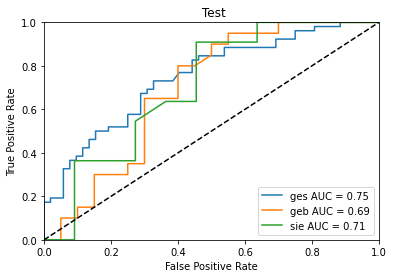

In [6]:
plot_test_roc(model, {'ges': test_ges, 'geb':test_geb, 'sie':test_sie}, device)

In [7]:
base_train_ges = DataLoader(CatsinomDataset('', '/project/catinous/lunadata/luna_lunacombined_dataset.csv', split='base_train', res='ges'), batch_size=8, num_workers=4)
device = torch.device('cuda')

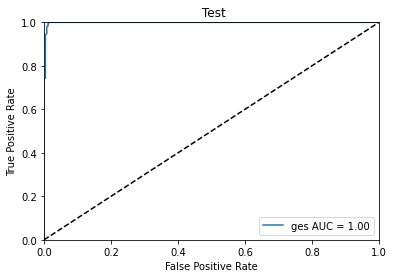

In [8]:
plot_test_roc(model, {'ges': base_train_ges}, device)